### 导入包

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from utils.PDE_Net import DeepONet_NS, weight_init
from utils.DataGenerate_DON import Dataset_DON, get_file
from torch.utils.tensorboard import SummaryWriter
from utils.utilities3 import *

torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 定义超参数

In [ ]:
dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

epochs = 1000
step_size = 50

batch_size = 300
learning_rate = 0.01
max_norm = 5

path_trained_model = r'trained_model'
path_label = r'train_data\label'

path_label_test_name = r'label_test.npy'
path_label_test = r'test_data'

#### 加载数据

In [4]:
train_label = torch.empty(0, p_x, p_y, 1)
file_list = os.listdir(path_label)
for file in file_list:
	if file.endswith('.npy'):
			label = np.load(os.path.join(path_label, file))
			train_label = torch.cat((train_label, torch.Tensor(label)), 0)

train_bc = np.concatenate((train_label[:,:,0,0], train_label[:,-1,:,0], train_label[:,:,-1,0], train_label[:,0,:,0]), axis=1)


train_label = train_label.reshape(train_label.shape[0],-1)

test_label = np.load(os.path.join(path_label_test, path_label_test_name))
test_bc = np.concatenate((test_label[:,:,0,0], test_label[:,-1,:,0], test_label[:,:,-1,0], test_label[:,0,:,0]), axis=1)
test_label = test_label.reshape(test_label.shape[0],-1)

train_label = torch.Tensor(train_label)
train_bc = torch.Tensor(train_bc)
test_data = torch.Tensor(test_label)
test_bc = torch.Tensor(test_bc)
print(train_label.shape)
print(train_bc.shape)
print(test_data.shape)
print(test_bc.shape)

(96, 51, 51, 1)
(96, 51, 51, 1)
(96, 204)
(96, 204)
(96, 2601)


归一化

In [5]:
x_normalizer = GaussianNormalizer(train_bc)
x_data = x_normalizer.encode(train_bc)
y_normalizer = GaussianNormalizer(train_label)
y_data = y_normalizer.encode(train_label)

x_normalizer_test = GaussianNormalizer(test_bc)
x_test = x_normalizer_test.encode(test_bc)
y_normalizer_test = GaussianNormalizer(test_label)
y_test = y_normalizer_test.encode(test_label)

定义网络、优化器、损失函数、学习率衰减策略

In [6]:
model = DeepONet_NS([204, 512, 512, 512, 512, 512], [2, 16, 64, 256, 512, 512, 512])
model.apply(weight_init)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
myloss = nn.MSELoss()

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True, min_lr=1e-6)

writer = SummaryWriter(r'runs\transtant_model')
begin_epoch = 0

unkown layer: MSELoss()
unkown layer: LeakyReLU(negative_slope=0.01)
unkown layer: LeakyReLU(negative_slope=0.01)
unkown layer: LeakyReLU(negative_slope=0.01)
unkown layer: LeakyReLU(negative_slope=0.01)
unkown layer: ModuleList(
  (0): Linear(in_features=204, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=512, out_features=512, bias=True)
)
unkown layer: PDE_ANN(
  (net): ModuleList(
    (0): Linear(in_features=204, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5

i:\ML\Package_model\DeepONet\original_model\DeepONet_NS.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_last = torch.tensor(torch.zeros(1), requires_grad=True, device=device)


加载模型

In [ ]:
# load_model(save_path, optimizer, model)
# save_path = r'part2part_model_state.pth'

file_list = os.listdir(path_trained_model)
if len(file_list) > 0:
	last_model = os.listdir(path_trained_model)[-1]
# save_path = os.path.join(path, 'model_{}.pth'.format(begin_epoch))
load_path = os.path.join(path_trained_model, last_model)
begin_epoch = load_model(load_path, optimizer, model)
model.to(device)

#### 加载数据

In [ ]:
train_loader = DataLoader(torch.utils.data.TensorDataset(x_data, y_data),batch_size=batch_size,shuffl=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),batch_size=batch_size,shuffl=True)

x, y = next(iter(train_loader))
print(torch.max(x))
print(torch.max(y))

开始训练

In [81]:
# epoch_num = 100000
coordinate = np.meshgrid(np.linspace(0,0.5,51), np.linspace(0,0.5,51))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)
'''
train_index = np.random.choice(2400,int(2400*0.8),replace=False)
test_index = np.setdiff1d(np.arange(2400),train_index,assume_unique=True)
train_x = x_data[train_index]
test_x = x_data[test_index]
train_y = y_data[train_index]
test_y = y_data[test_index]

train_x = train_x.to(device)
train_y =train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)
'''
coordinate = torch.Tensor(coordinate).to(device)

for epoch in range(epochs):
	model.train()
	train_loss_epoch = 0
	test_loss_epoch = 0
	for batch in train_loader:
		loss_train = 0
		data_x,data_y = batch

		x = data_x.float().to(device)
		y = data_y.float().to(device)

		pred = model(x, coordinate)

		pred = y_normalizer.decode(pred)
		y = y_normalizer.decode(y)

		loss_train = myloss(pred.clone(), y.clone())

		optimizer.zero_grad()
		train_loss_epoch = train_loss_epoch + loss_train.item()
		loss_train.backward(retain_graph=True)
		torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
		optimizer.step()
	train_loss_epoch = train_loss_epoch / len(train_loader)
	print('epoch:', epoch, 'loss_train:', train_loss_epoch)
	scheduler.step(train_loss_epoch)

	model.eval()
	with torch.no_grad():
		for batch_test in test_loader:
			loss_test = 0
			test_x,test_y = batch_test
			
			test_x = test_x.float().to(device)			# [length,time_step,51,51,3]
			test_y = test_y.float().to(device)			# [length,time_step,51,51,3]

			pred_test = model(test_x)

			pred_test = y_normalizer_test.decode(pred_test)
			test_y = y_normalizer_test.decode(test_y)

			loss_test = myloss(pred_test.clone(), test_y.clone())

			test_loss_epoch = test_loss_epoch + loss_test.item()
		test_loss_epoch = test_loss_epoch/len(test_loader)
		print('epoch:', epoch, 'loss_test:', test_loss_epoch)

	if epoch % 2000 == 0:
		save_path = os.path.join(path_trained_model, 'DON_{}.pth'.format(epoch))
		save_model(save_path, epoch, optimizer, model)

		writer.add_scalar('loss_train', loss_train.item(), epoch)
		writer.add_scalar('loss_test', loss_test.item(), epoch)

	

# 以下为废案

### 测试

In [ ]:
clone = torch.load('model_full_data_2D_turbulence.pth')
clone.eval()
with torch.no_grad():
	u_pred = clone(test_bc[:,:,0],test_coordinates)
	v_pred = clone(test_bc[:,:,1],test_coordinates)
	p_pred = clone(test_bc[:,:,2],test_coordinates)
loss = loss_func(u_pred, test_variables[:,:,0]) + loss_func(v_pred, test_variables[:,:,1]) + loss_func(p_pred, test_variables[:,:,2])
print(loss.item())
u_pred = u_pred.cpu().detach().numpy().reshape(-1,51,51)
v_pred = v_pred.cpu().detach().numpy().reshape(-1,51,51)
p_pred = p_pred.cpu().detach().numpy().reshape(-1,51,51)
data = np.stack((u_pred,v_pred,p_pred),axis=3)
print(data.shape)

# 反归一化
inverse_data = dataset.inverse_normal(data,test_min,test_max)

查看测试集的准确率

In [ ]:
pred_index = 10
u_pred = inverse_data[pred_index,:,:,0]
v_pred = inverse_data[pred_index,:,:,1]
p_pred = inverse_data[pred_index,:,:,2]
print(u_pred.shape)

画预测图

In [ ]:
mag = np.sqrt(u_pred**2 + v_pred**2)
fig = plt.figure()
ax = fig.add_subplot(111)
contour = ax.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag, 100, cmap='jet')
plt.colorbar(contour)
plt.show()

In [ ]:
print(train_variables.shape)

原始数据

In [ ]:
original_variables = test_variables.cpu().detach().numpy().reshape(-1,51,51,3)
original_data = dataset.inverse_normal(original_variables,test_min,test_max)
u_original = original_data[pred_index,:,:,0]
v_original = original_data[pred_index,:,:,1]
p_original = original_data[pred_index,:,:,2]

mag = np.sqrt(u_original**2 + v_original**2)
fig = plt.figure()
ax = fig.add_subplot(111)
contour = ax.contourf(train_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), train_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag, 100, cmap='jet')
plt.colorbar(contour)
plt.show()

误差图

In [ ]:
def error(pred,original):
	return np.sqrt((pred-original)**2)
u_error = error(u_pred,u_original)
v_error = error(v_pred,v_original)
p_error = error(p_pred,p_original)
mag_error = error(np.sqrt(u_pred**2 + u_pred**2),np.sqrt(u_original**2 + v_original**2))
print(u_error.shape)

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(20,5))
axs[0].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), u_error, 100, cmap='jet')
axs[1].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), v_error, 100, cmap='jet')
axs[2].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), p_error, 100, cmap='jet')
axs[3].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag_error, 100, cmap='jet')
plt.colorbar(contour)
plt.show()

总误差

In [ ]:
def total_error(pred,original):
	return np.sqrt(np.mean((pred-original)**2))
u_tol_error = total_error(inverse_data[:,:,:,0],original_data[:,:,:,0])
v_tol_error = total_error(inverse_data[:,:,:,1],original_data[:,:,:,1])
p_tol_error = total_error(inverse_data[:,:,:,2],original_data[:,:,:,2])
mag_tol_error = total_error(np.sqrt(inverse_data[:,:,:,0]**2 + inverse_data[:,:,:,1]**2),np.sqrt(original_data[:,:,:,0]**2 + original_data[:,:,:,1]**2))

In [ ]:
print(u_tol_error)
print(v_tol_error)
print(p_tol_error)
print(mag_tol_error)

In [60]:
a = np.array([[1,2,3],[4,5,6]])
# [2,3]
b = np.mean(a,axis=0)
print(b)

[2.5 3.5 4.5]


### 拼接测试

In [7]:
save_path = r'I:\ML\Package_model\DeepONet\original_model\part2part_model_state.pth'
load_model(save_path, optimizer, model)
model.eval()
points_list=[]
datafile = r'I:\ML\Package_model\DeepONet\train_data\unseen_zone'
dataset = Dataset_DON(datafile,points_list,1,True)
test_bc,test_variable,test_coordinate,test_min,test_max = dataset.get_data()
# print(np.tile(np.mean(test_bc[:,51:102,0],axis=1),(51,1)).T.shape)
# print(test_bc[:,51:102,0].shape)
# test_bc[:,51:102,0] = np.mean(np.mean(test_bc[:,51:102,0],axis=1),(51,1)).T
print(test_bc.shape)
print(test_coordinate.shape)
print(test_variable.shape)
print(test_min.shape)
print(test_max.shape)
# 查看归一化是否正确
print(np.max(test_variable))

Load model at epoch: 35200
(96, 204, 3)
(2601, 2)
(96, 2601, 3)
(96, 3)
(96, 3)
1.365959614255422


In [8]:
test_bc = torch.from_numpy(test_bc).to(device)
test_coordinate = torch.from_numpy(test_coordinate).to(device)
test_variable = torch.from_numpy(test_variable).to(device)

In [9]:
def loss_func(output, label):
	mse_loss = nn.MSELoss()
	loss = mse_loss(output, label)
	return loss

In [10]:
with torch.no_grad():
	u_pred = model(test_bc[:,:,0],test_coordinate)
	v_pred = model(test_bc[:,:,1],test_coordinate)
	p_pred = model(test_bc[:,:,2],test_coordinate)
loss = loss_func(u_pred, test_variable[:,:,0]) + loss_func(v_pred, test_variable[:,:,1]) + loss_func(p_pred, test_variable[:,:,2])
print(loss.item())
u_pred = u_pred.cpu().detach().numpy().reshape(-1,51,51)
v_pred = v_pred.cpu().detach().numpy().reshape(-1,51,51)
p_pred = p_pred.cpu().detach().numpy().reshape(-1,51,51)
data = np.stack((u_pred,v_pred,p_pred),axis=3)
print(data.shape)
# 反归一化
inverse_data = dataset.inverse_normalize(data,test_min,test_max)

0.05469275528758506
(96, 51, 51, 3)


In [11]:
pred_index = 0
u_pred = inverse_data[:,:,:,0]
v_pred = inverse_data[:,:,:,1]
p_pred = inverse_data[:,:,:,2]
mag = np.sqrt(u_pred**2 + v_pred**2)
print(mag.shape)

(96, 51, 51)


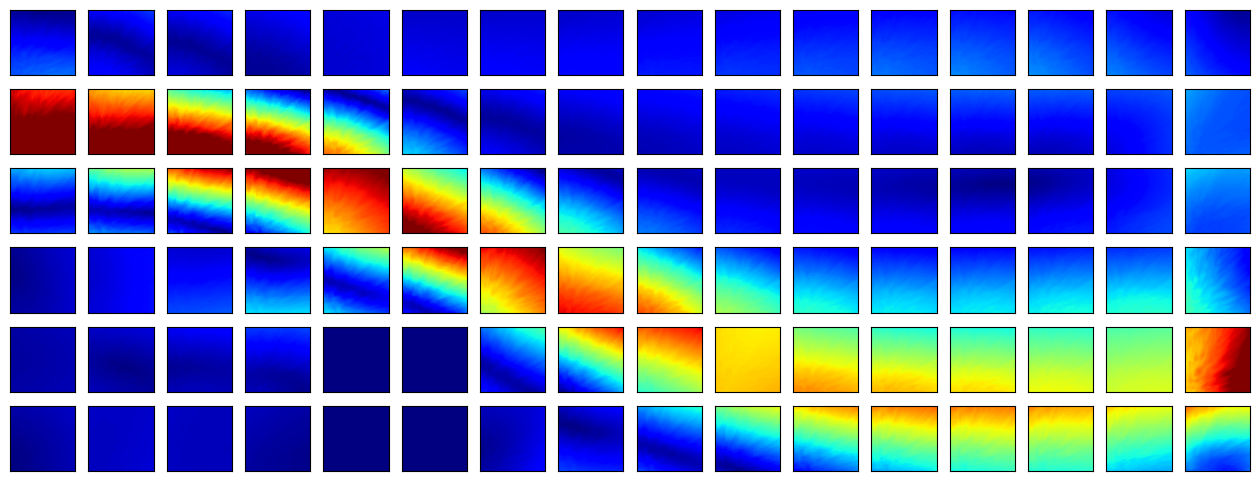

In [12]:
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(test_coordinate.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinate.cpu().detach().numpy()[:,1].reshape(51,51), mag[i+j*6,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])
# plt.colorbar()

plt.show()

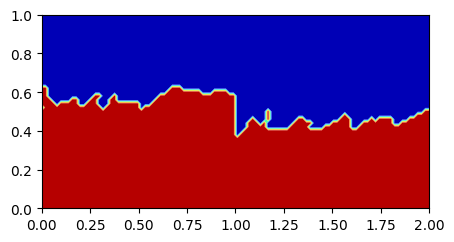

In [33]:
image1 = mag[4]
image2 = mag[10]
import cv2
import numpy as np

# 将两个矩阵进行加权平均，生成平滑后的矩阵
smoothed_matrix = cv2.addWeighted(image1, 0.5, image2, 0.5, 0)

# 创建[51, 101]的空矩阵
result_matrix = np.zeros((51, 102), dtype=np.uint8)

# 将平滑后的矩阵拼接到空矩阵中
result_matrix[:, :51] = image1
result_matrix[:, 51:] = smoothed_matrix

fig,axs = plt.subplots(1,1,figsize=(5,5))
coordinate = np.meshgrid(np.linspace(0,2,102),np.linspace(0,1,51))
axs.contourf(coordinate[0], coordinate[1], result_matrix, 10, cmap='jet', antialiased=True, vmin=0, vmax=1)
axs.set_aspect('equal')


In [13]:
all_zone = np.zeros((300,800))
for i in range(6):
	for j in range(16):
		if i == 5 and j != 15:
			all_zone[-51:,j*50:(j+1)*50+1] = mag[i+j*6]
		elif i != 5 and j == 15:
			all_zone[i*50:(i+1)*50+1,-51:] = mag[i+j*6]
		elif i == 5 and j == 15:
			all_zone[-51:,-51:] = mag[i+j*6]
		else:
			all_zone[i*50:(i+1)*50+1,j*50:(j+1)*50+1] = mag[i+j*6]

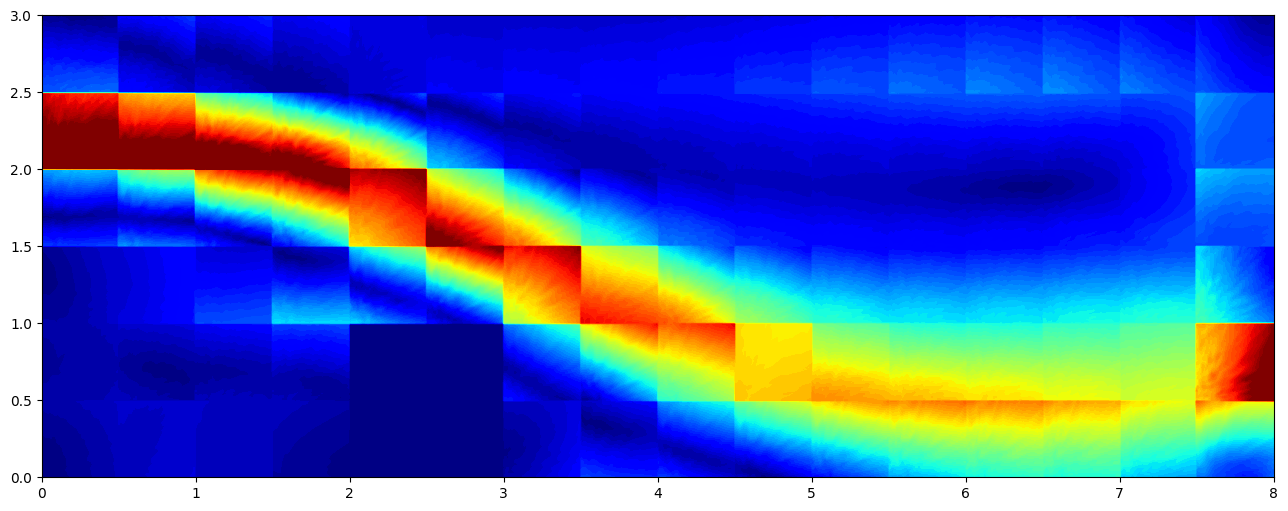

In [14]:
fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

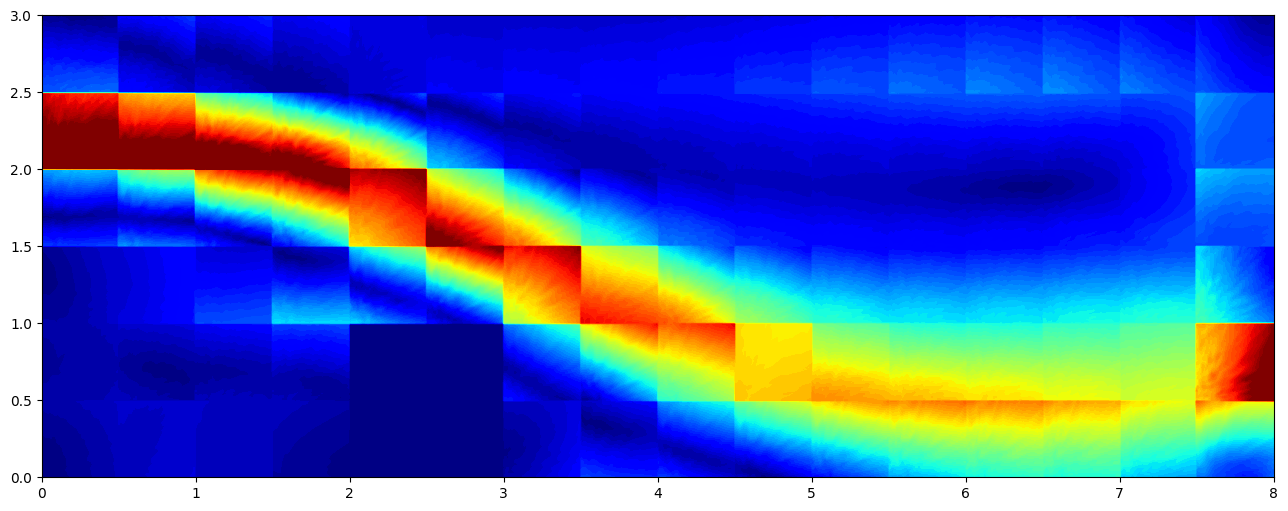

In [74]:
import numpy as np
from scipy.ndimage import gaussian_filter

# 假设有一个300x800的数据矩阵，保存在名为data_matrix的变量中
data_matrix = all_zone

# 定义平滑滤波器的标准差
sigma_x = 1.0  # x方向上的标准差
sigma_y = 1.0  # y方向上的标准差

# 使用二维高斯滤波器对矩阵进行平滑处理
smoothed_matrix = gaussian_filter(data_matrix, (sigma_x, sigma_y))
fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

In [50]:
import cv2 as cv
import numpy as np

img = np.uint8(all_zone)
h = img.shape[0]
w = img.shape[1]

# 均值滤波
img_Blur_3 = cv.blur(img, (3, 3))   # 3*3均值滤波
img_Blur_5 = cv.blur(img, (5, 5))   # 5*5均值滤波

# # 中值滤波
# img_MedianBlur_3 = cv.medianBlur(img, 3)    # 3*3中值滤波
# img_MedianBlur_5 = cv.medianBlur(img, 5)    # 5*5中值滤波

# # 超限像素平滑法
# def overrun_pixel_smoothing(kernel, image):
#     img_overrun = image.copy()
#     filter = np.zeros((kernel, kernel), np.uint8)
#     average = np.zeros((h - kernel + 1, w - kernel + 1), np.uint8)  # 平均值矩阵

#     for i in range(h - kernel + 1):
#         for j in range(w - kernel + 1):

#             for m in range(kernel):
#                 for n in range(kernel):
#                     filter[m, n] = img_overrun[i + m, j + n]

#             average[i, j] = 1 / (kernel * kernel) * filter.sum()  # 求平均

#     T = 50  # 设定阈值

#     for i in range(h - kernel + 1):
#         for j in range(w - kernel + 1):

#             if abs(img[i + kernel - 2, j + kernel - 2] - average[i, j]) > T:
#                 img_overrun[i + kernel - 2, j + kernel - 2] = average[i, j]

#     return img_overrun


# img_overrun_3 = overrun_pixel_smoothing(3, img)  # 核大小为3*3
# img_overrun_5 = overrun_pixel_smoothing(5, img)  # 核大小为5*5

# # 有选择保边缘平滑法
# img_EdgeKeeping = img.copy()

# filter = np.zeros((5, 5), np.uint8)

# for i in range(h - 4):
#     for j in range(w - 4):

#         for m in range(5):
#             for n in range(5):
#                 filter[m, n] = img_EdgeKeeping[i + m, j + n]

#         mask = []

#         # 3*3掩膜
#         mask.append([filter[1, 1], filter[1, 2], filter[1, 3], filter[2, 1], filter[2, 2], filter[2, 3], filter[3, 1], filter[3, 2], filter[3, 3]])

#         # 5*5掩膜
#         mask.append([filter[2, 2], filter[1, 1], filter[1, 2], filter[1, 3], filter[0, 1], filter[0, 2], filter[0, 3]])
#         mask.append([filter[2, 2], filter[1, 1], filter[2, 1], filter[3, 1], filter[1, 0], filter[2, 0], filter[3, 0]])
#         mask.append([filter[2, 2], filter[3, 1], filter[3, 2], filter[3, 3], filter[4, 1], filter[4, 2], filter[4, 3]])
#         mask.append([filter[2, 2], filter[1, 3], filter[2, 3], filter[3, 3], filter[1, 4], filter[2, 4], filter[3, 4]])

#         # 6*6掩膜
#         mask.append([filter[2, 2], filter[3, 2], filter[2, 3], filter[3, 3], filter[4, 3], filter[3, 4], filter[4, 4]])
#         mask.append([filter[2, 2], filter[2, 3], filter[1, 2], filter[1, 3], filter[1, 4], filter[0, 3], filter[0, 4]])
#         mask.append([filter[2, 2], filter[1, 2], filter[2, 1], filter[1, 1], filter[0, 1], filter[1, 0], filter[0, 0]])
#         mask.append([filter[2, 2], filter[2, 1], filter[3, 2], filter[3, 1], filter[3, 0], filter[4, 1], filter[4, 0]])

#         # 求各掩膜的方差
#         var = []
#         for k in range(9):
#             var.append(np.var(mask[k]))

#         index = var.index(min(var))  # 方差最小的掩膜对应的索引号
#         img_EdgeKeeping[i + 2, j + 2] = np.mean(mask[index])


cv.imshow("image", img)
cv.imshow("img_Blur_3", img_Blur_3)
cv.imshow("img_Blur_5", img_Blur_5)
# cv.imshow("img_MedianBlur_3", img_MedianBlur_3)
# cv.imshow("img_MedianBlur_5", img_MedianBlur_5)
# cv.imshow("img_overrun_3", img_overrun_3)
# cv.imshow("img_overrun_5", img_overrun_5)
# cv.imshow("img_EdgeKeeping", img_EdgeKeeping)

cv.waitKey(0)
cv.destroyAllWindows()


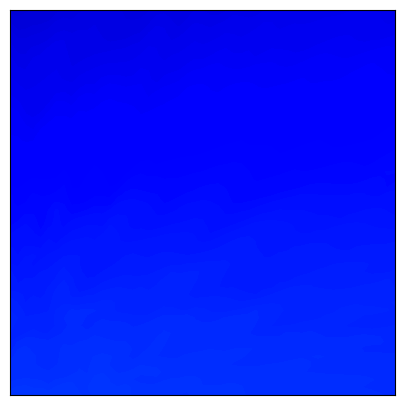

In [9]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.contourf(test_coordinate.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinate.cpu().detach().numpy()[:,1].reshape(51,51), mag[59,:,:], 100, cmap='jet', vmin=0, vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# plt.colorbar()

plt.show()

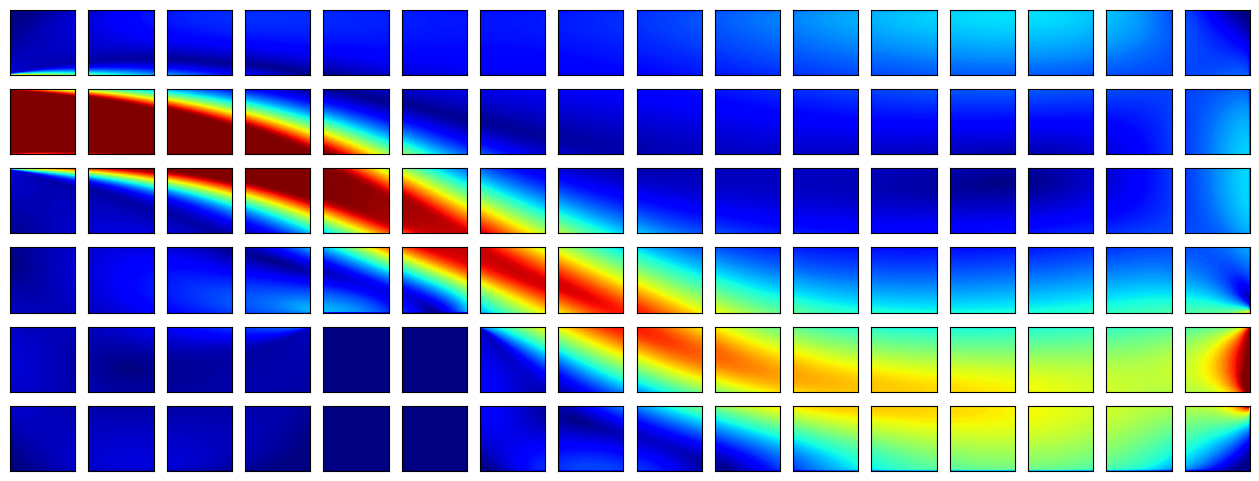

In [10]:
original_variables = test_variable.cpu().detach().numpy().reshape(-1,51,51,3)
original_data = dataset.inverse_normalize(original_variables,test_min,test_max)
u_original = original_data[:,:,:,0]
v_original = original_data[:,:,:,1]
p_original = original_data[:,:,:,2]

mag_original = np.sqrt(u_original**2 + v_original**2)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# contour = ax.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag, 100, cmap='jet')
# plt.colorbar(contour)
# plt.show()
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(test_coordinate.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinate.cpu().detach().numpy()[:,1].reshape(51,51), mag_original[i+j*6,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])
plt.show()

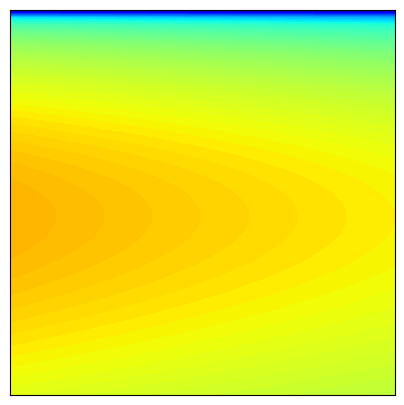

In [85]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.contourf(test_coordinate.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinate.cpu().detach().numpy()[:,1].reshape(51,51), mag_original[59,:,:], 100, cmap='jet', vmin=0, vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# plt.colorbar()

plt.show()

测试用流量守恒，水平流量全由水平方向流出，垂直方向全由垂直方向流出，边界设为平均值。测试位置：59

In [146]:
test_bc59 = test_bc.cpu().detach().numpy()[59:60,:,:]
print(test_bc59)

[[[0.86530974 0.02643614 0.71445357]
  [0.87443124 0.04316237 0.73273602]
  [0.88337736 0.06029634 0.75083857]
  [0.89213593 0.07783247 0.76872462]
  [0.90069423 0.09576399 0.78635558]
  [0.90903886 0.11408293 0.80369078]
  [0.91715574 0.13277995 0.82068738]
  [0.92503004 0.15184436 0.83730023]
  [0.93264608 0.17126399 0.85348174]
  [0.93998724 0.1910252  0.86918171]
  [0.94703585 0.21111272 0.8843471 ]
  [0.95377291 0.23150974 0.89892169]
  [0.96017789 0.25219776 0.91284575]
  [0.96622824 0.2731567  0.92605543]
  [0.97189882 0.29436482 0.93848201]
  [0.97716096 0.31579915 0.95005043]
  [0.98198174 0.337435   0.96067655]
  [0.98632424 0.35924556 0.97026562]
  [0.9901488  0.38120166 0.97871438]
  [0.99341383 0.40327165 0.98591462]
  [0.99607623 0.42542086 0.99175541]
  [0.99809162 0.44761206 0.99612423]
  [0.99941444 0.46980585 0.99890809]
  [0.99999861 0.49196056 0.99999552]
  [0.99979837 0.51403355 0.99927936]
  [0.99876922 0.53598088 0.99665905]
  [0.99686902 0.55775976 0.99204419]
 

In [147]:
test_bc59[:,102:153,0] = np.mean(test_bc59[:,:51,0],axis=1)
test_bc59[:,102:153,1] = np.mean(test_bc59[:,:51,1],axis=1)
test_bc59[:,102:153,2] = np.mean(test_bc59[:,:51,2],axis=1)

test_bc59[:,153:204,0] = np.mean(test_bc59[:,51:102,0],axis=1)
test_bc59[:,153:204,1] = np.mean(test_bc59[:,51:102,1],axis=1)
test_bc59[:,153:204,2] = np.mean(test_bc59[:,51:102,2],axis=1)

# test_bc59[:,102:153,0] = 0
# test_bc59[:,102:153,1] = 0
# test_bc59[:,102:153,2] = 0

# test_bc59[:,153:204,0] = 0
# test_bc59[:,153:204,1] = 0
# test_bc59[:,153:204,2] = 0

# test_bc59[:,102:153,0] = test_bc59[:,:51,0]
# test_bc59[:,102:153,1] = test_bc59[:,:51,1]
# test_bc59[:,102:153,2] = test_bc59[:,:51,2]

# test_bc59[:,153:204,0] = test_bc59[:,51:102,0]
# test_bc59[:,153:204,1] = test_bc59[:,51:102,1]
# test_bc59[:,153:204,2] = test_bc59[:,51:102,2]

In [148]:
test_bc59 = torch.from_numpy(test_bc59).to(device)
print(test_bc59.shape)

torch.Size([1, 204, 3])


In [149]:
with torch.no_grad():
	u_pred = model(test_bc59[:,:,0],test_coordinates)
	v_pred = model(test_bc59[:,:,1],test_coordinates)
	p_pred = model(test_bc59[:,:,2],test_coordinates)

In [150]:
loss = loss_func(u_pred, test_variables[59:60,:,0]) + loss_func(v_pred, test_variables[59:60,:,1]) + loss_func(p_pred, test_variables[59:60,:,2])
print(loss.item())

0.10678149389344511


In [151]:
u_pred = u_pred.cpu().detach().numpy().reshape(-1,51,51)
v_pred = v_pred.cpu().detach().numpy().reshape(-1,51,51)
p_pred = p_pred.cpu().detach().numpy().reshape(-1,51,51)
data = np.stack((u_pred,v_pred,p_pred),axis=3)
print(data.shape)
# 反归一化
inverse_data = dataset.inverse_normalize(data,test_min[59:60],test_max[59:60])

(1, 51, 51, 3)


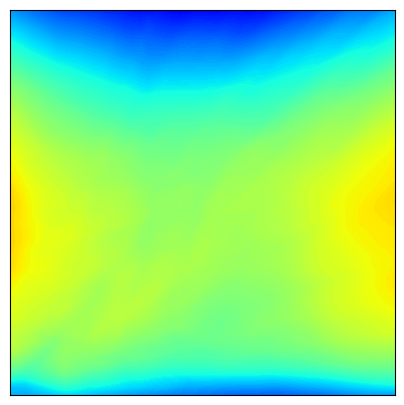

In [152]:
mag59 = np.sqrt(inverse_data[:,:,:,0]**2 + inverse_data[:,:,:,1]**2)
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag59[0], 100, cmap='jet', vmin=0, vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# plt.colorbar()

plt.show()

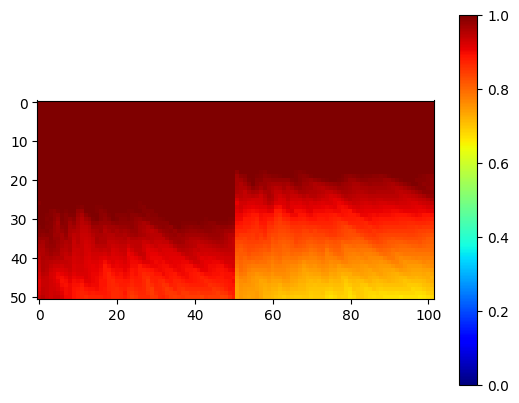

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
import cv2

# 加载小图片
matrix1 = mag[4]
matrix2 = mag[10]

matrix = np.concatenate((matrix1,matrix2),axis=1)
mask = np.zeors((matrix1.shape[0],20))



# 绘制云图
plt.imshow(matrix, cmap='jet',vmax=1,vmin=0)
plt.colorbar()
plt.show()



C:\Users\Administrator\AppData\Local\Temp\ipykernel_26720\1671756800.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interpolate.interp2d(x, y, z, kind='cubic')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26720\1671756800.py:15: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

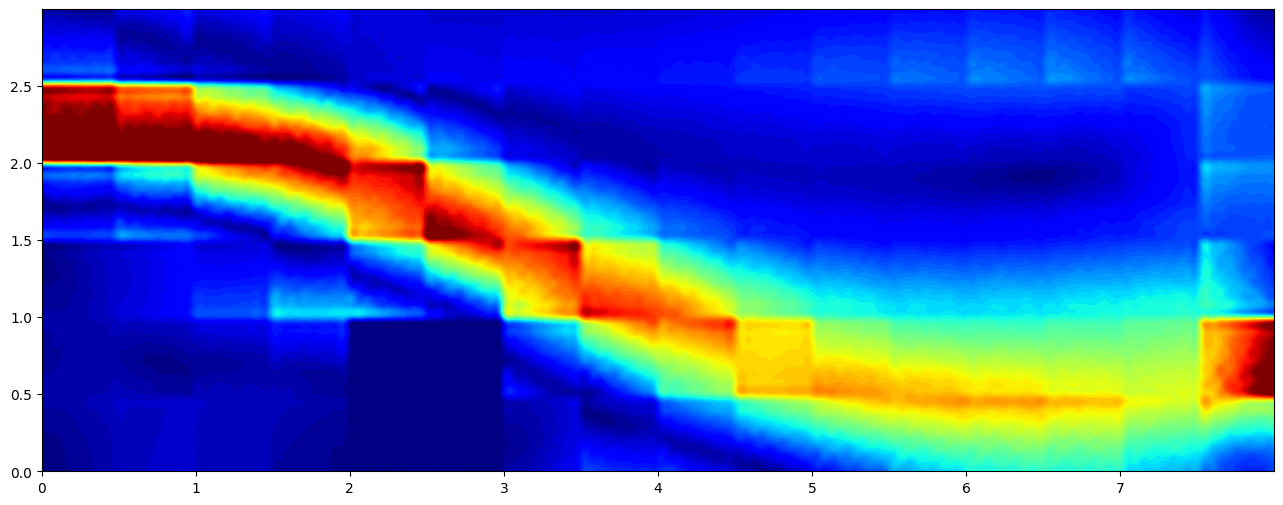

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

interval = 5
x = np.linspace(0, 8, int(800/interval))
y = np.linspace(0, 3, int(300/interval))
xx, yy = np.meshgrid(x, y) #建立原始坐标
z = all_zone[::interval,::interval]

f = interpolate.interp2d(x, y, z, kind='cubic')

xnew = np.arange(0, 8, 1e-3)
ynew = np.arange(0, 3, 1e-3)
znew = f(xnew, ynew) #插值后的数据


fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(xnew,ynew,znew,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')


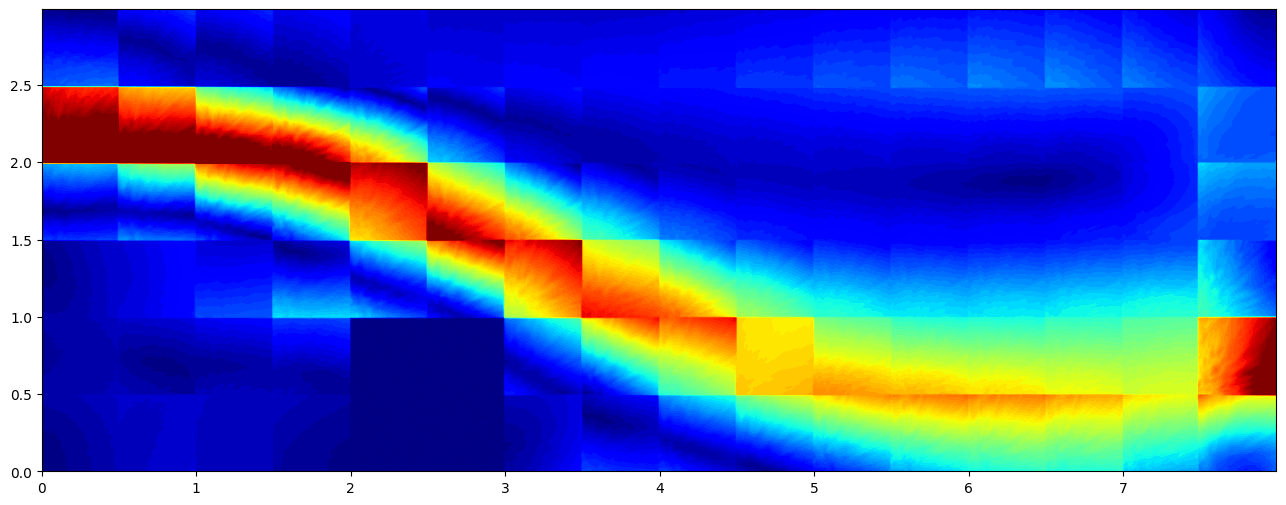

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d, convolve2d, savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.fft import fft2, ifft2

# 准备数据集
data = all_zone  # 二维矩阵，形状为 (300, 800)

# 中值滤波
# smoothed_data = medfilt2d(data, kernel_size=9)

# 高斯加权平均滤波
# sigma = 6  # 高斯滤波的标准差
# smoothed_data = gaussian_filter(data, sigma=sigma)

# 移动平均法滤波处理
# window_size = 20  # 移动平均窗口的大小
# kernel = np.ones((window_size, window_size)) / (window_size**2)
# smoothed_data = convolve2d(data, kernel, mode='same')

# 加权平均法滤波处理
# weights = np.array([[1, 2, 1],
#                     [2, 2, 2],
#                     [1, 2, 1]])  # 加权平均的权重矩阵
# weights = weights / np.sum(weights)  # 归一化权重矩阵
# smoothed_data = convolve2d(data, weights, mode='same')

# Savitzky-Golay滤波处理
# window_size = 50  # 滤波窗口的大小
# poly_order = 2  # 多项式拟合的阶数
# smoothed_data = savgol_filter(data, window_length=window_size, polyorder=poly_order)

# 傅里叶变换
f_data = fft2(data)

# 频域滤波（在此示例中，假设我们想去除低频分量，保留高频分量）
cutoff = 1  # 截止频率
f_data[np.abs(f_data) < cutoff] = 0

# 逆傅里叶变换
smoothed_data = np.real(ifft2(f_data))

# 绘制等高线图
xnew = np.arange(0, 8, 1e-2)
ynew = np.arange(0, 3, 1e-2)

fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(xnew,ynew,smoothed_data,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

class GP:
    def __init__(self, num_x_samples):
        self.observations = {"x": list(), "y": list()}
        self.num_x_samples = num_x_samples
        self.x_samples = np.arange(0, 10.0, 10.0 / self.num_x_samples).reshape(-1, 1)
        
        # prior
        self.mu = np.zeros_like(self.x_samples)
        self.cov = self.kernel(self.x_samples, self.x_samples)
        
    def update(self, observations):
        self.update_observation(observations)
        
        x = np.array(self.observations["x"]).reshape(-1, 1)
        y = np.array(self.observations["y"]).reshape(-1, 1)
        
        K11 = self.cov  # (N,N)
        K22 = self.kernel(x, x) # (k,k)
        K12 = self.kernel(self.x_samples, x)  # (N,k)
        K21 = self.kernel(x, self.x_samples)  # (k,N)
        K22_inv = np.linalg.inv(K22 + 1e-8 * np.eye(len(x)))  # (k,k)
        
        self.mu = K12.dot(K22_inv).dot(y)
        self.cov = self.kernel(self.x_samples, self.x_samples) - K12.dot(K22_inv).dot(K21)
        
    def visualize(self, num_gp_samples=3):
        gp_samples = np.random.multivariate_normal(
            mean=self.mu.ravel(), 
            cov=self.cov, 
            size=num_gp_samples)
        x_sample = self.x_samples.ravel()
        mu = self.mu.ravel()
        uncertainty = 1.96 * np.sqrt(np.diag(self.cov))

        plt.figure()
        plt.fill_between(x_sample, mu + uncertainty, mu - uncertainty, alpha=0.1)
        plt.plot(x_sample, mu, label='Mean')
        for i, gp_sample in enumerate(gp_samples):
            plt.plot(x_sample, gp_sample, lw=1, ls='--', label=f'Sample {i+1}')
            
        plt.plot(self.observations["x"], self.observations["y"], 'rx')
        plt.legend()
        plt.grid()

    def update_observation(self, observations):
        for x, y in zip(observations["x"], observations["y"]):
            if x not in self.observations["x"]:
                self.observations["x"].append(x)
                self.observations["y"].append(y)
                
    @staticmethod
    def kernel(x1, x2, l=0.5, sigma_f=0.2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)


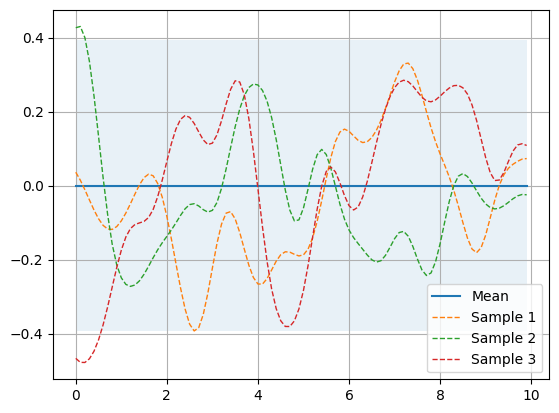

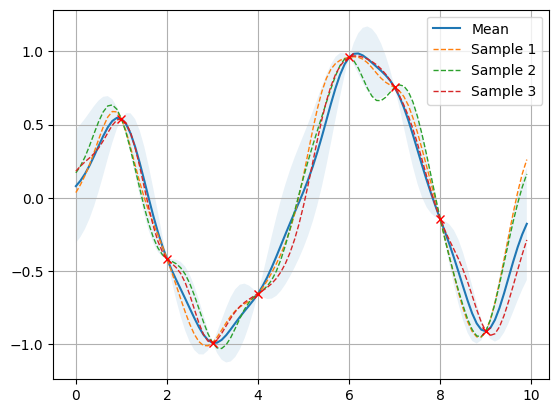

In [56]:
def y(x):
    x = np.asarray(x)
    return np.cos(x).tolist() 

gp = GP(num_x_samples=100)
gp.visualize()

# for _ in range(5):
#     obs_x = np.random.uniform(0, 10, size=2).tolist()
#     gp.update({"x": obs_x, "y": y(obs_x)})
#     gp.visualize()

obs_x = [1, 2, 3, 4, 6, 7, 8, 9]
gp.update({"x": obs_x, "y": y(obs_x)})
gp.visualize()

In [13]:
from scipy.optimize import minimize


class GPR:
    
    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.optimize = optimize
       
    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)
        
         # hyper parameters optimization
        def negative_log_likelihood_loss(params):
            self.params["l"], self.params["sigma_f"] = params[0], params[1]
            Kyy = self.kernel(self.train_X, self.train_X) + 1e-8 * np.eye(len(self.train_X))
            loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return loss.ravel()
                
        if self.optimize:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]], 
                   bounds=((1e-4, 1e4), (1e-4, 1e4)),
                   method='L-BFGS-B')
            self.params["l"], self.params["sigma_f"] = res.x[0], res.x[1]
        
        self.is_fit = True
    
    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return
        
        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)
        
        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

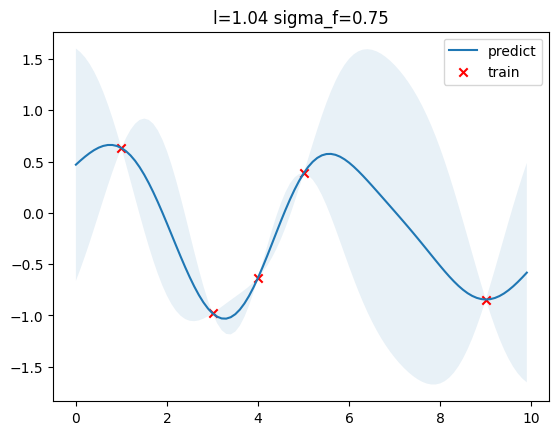

In [68]:
def y(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape) 
    return y.tolist() 

train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y(train_X, noise_sigma=0.1)
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

gpr = GPR(optimize=True)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

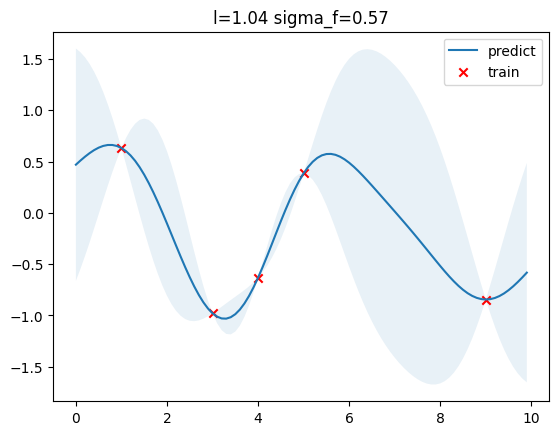

In [69]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernel = ConstantKernel(constant_value=0.2, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.kernel_.k2.length_scale, gpr.kernel_.k1.constant_value))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

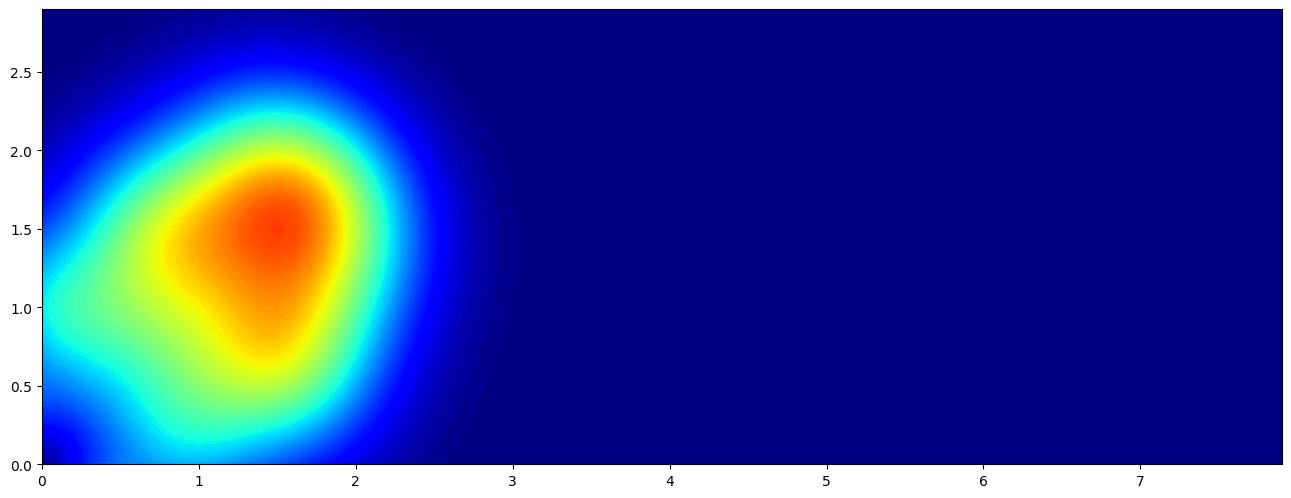

In [14]:
%matplotlib inline
def y_2d(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.sin(0.5 * np.linalg.norm(x, axis=1)) 
    y += np.random.normal(0, noise_sigma, size=y.shape)
    return y
    
train_X = all_zone[::5,::5].reshape(-1, 2).tolist()
train_y = y_2d(train_X, noise_sigma=1e-4)

test_d1 = np.arange(0, 8, 0.1)
test_d2 = np.arange(0, 3, 0.1)
test_d1, test_d2 = np.meshgrid(test_d1, test_d2)
test_X = [[d1, d2] for d1, d2 in zip(test_d1.ravel(), test_d2.ravel())]

gpr = GPR(optimize=False)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
z = mu.reshape(test_d1.shape)

# fig = plt.figure(figsize=(16, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.contourf(test_d1, test_d2, z, zdir='z', offset=0, cmap=cm.coolwarm, alpha=0.6)
# ax.plot_surface(test_d1, test_d2, z, cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
# ax.scatter(np.asarray(train_X)[:,0], np.asarray(train_X)[:,1], train_y, c=train_y, cmap=cm.coolwarm)
# ax.contourf(test_d1, test_d2, z, zdir='z', offset=0, cmap=cm.coolwarm, alpha=0.6)
# ax.set_title("with optimization l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(test_d1,test_d2,z,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')


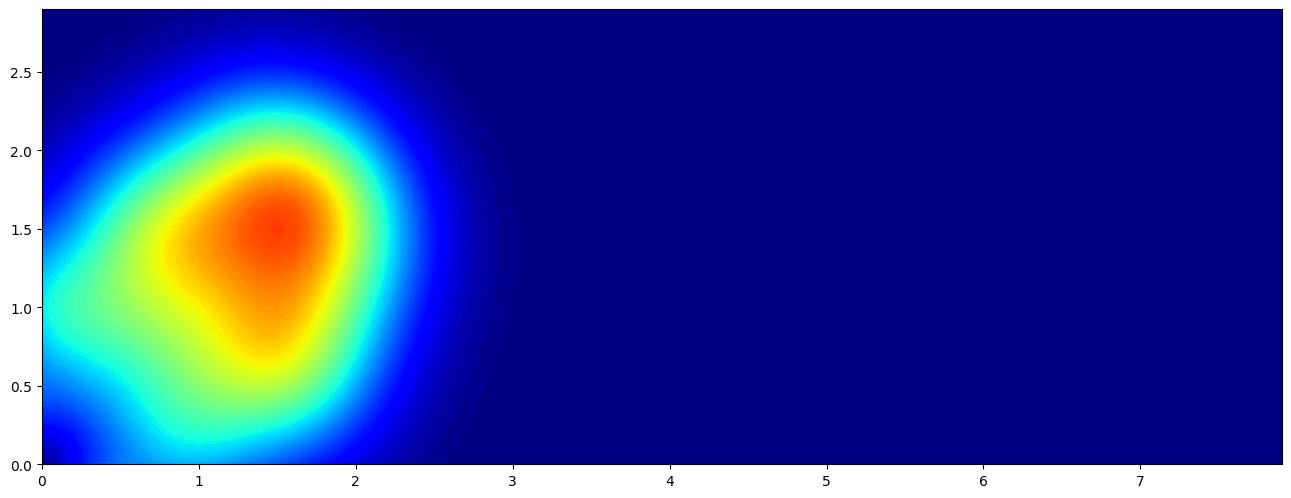

In [15]:
fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(test_d1,test_d2,z,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

In [ ]:
kernel = ConstantKernel(constant_value=0.2, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
matrix = all_zone[::5,::5]
X = np.indices(matrix.shape).reshape(2, -1).T  # 输入特征矩阵，形状为 (n_samples, n_features)
y = matrix.flatten()  # 目标值数组，长度为 n_samples
kernel = RBF()  # 使用 RBF 核函数，可以根据需求选择其他核函数
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)
X_new = np.indices(matrix.shape).reshape(2, -1).T  # 新的输入特征矩阵，形状为 (n_new_samples, n_features)
y_pred = gpr.predict(X_new)  # 使用拟合后的回归器进行预测


NameError: name 'all_zone' is not defined

In [ ]:
print(y_pred.shape)

# 以上为废案

### 重新用速度大小值训练后测试

In [29]:
file_list = os.listdir(path_trained_model)
if len(file_list) > 0:
	last_model = get_file(path_trained_model)[-1]
load_path = os.path.join(path_trained_model, last_model)

begin_epoch = load_model(save_path, optimizer, model)
model.to(device)

model.eval()

train_label = np.load(r'train_data/train_data_velocity.npy')
# test_data = np.load(r'train_data/train_data_velocity.npy')
# train_data = np.concatenate((train_data,test_data),axis=0)
print(train_label.shape)
# print(test_data.shape)

train_bc = np.concatenate((train_label[:,:,0,0], train_label[:,-1,:,0], train_label[:,:,-1,0], train_label[:,0,:,0]), axis=1)
# test_bc = np.concatenate((test_data[:,:,0,0], test_data[:,-1,:,0], test_data[:,:,-1,0], test_data[:,0,:,0]), axis=1)
print(train_bc.shape)
# print(test_bc.shape)

train_label = train_label.reshape(train_label.shape[0],-1)
print(train_label.shape)
train_label = torch.Tensor(train_label)
train_bc = torch.Tensor(train_bc)
# test_data = torch.Tensor(test_data)
# test_bc = torch.Tensor(test_bc)

Load model at epoch: 4000
(96, 51, 51, 1)
(96, 51, 51, 1)
(96, 204)
(96, 204)
(96, 2601)


In [30]:
x_normalizer = GaussianNormalizer(train_bc)
x_data = x_normalizer.encode(train_bc)
y_normalizer = GaussianNormalizer(train_label)
y_data = y_normalizer.encode(train_label)

In [31]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x), np.linspace(0,dx,p_y))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)

x_data = x_data.to(device)
y_data = y_data.to(device)

coordinate = torch.Tensor(coordinate).to(device)

In [32]:
myloss = nn.MSELoss()

In [33]:
model.eval()
with torch.no_grad():
	pred_test = model(x_data, coordinate)			# [train_size,1089]
	pred_test = y_normalizer.decode(pred_test)
	y_data = y_normalizer.decode(y_data)
loss = myloss(pred_test, y_data)
print(loss.item())

# # 反归一化
# v_pred = x_normalizer.decode(v_pred)

19.94422315271704


In [34]:
v_pred = v_pred.reshape(96,51,51)
v_pred = v_pred.cpu().numpy()

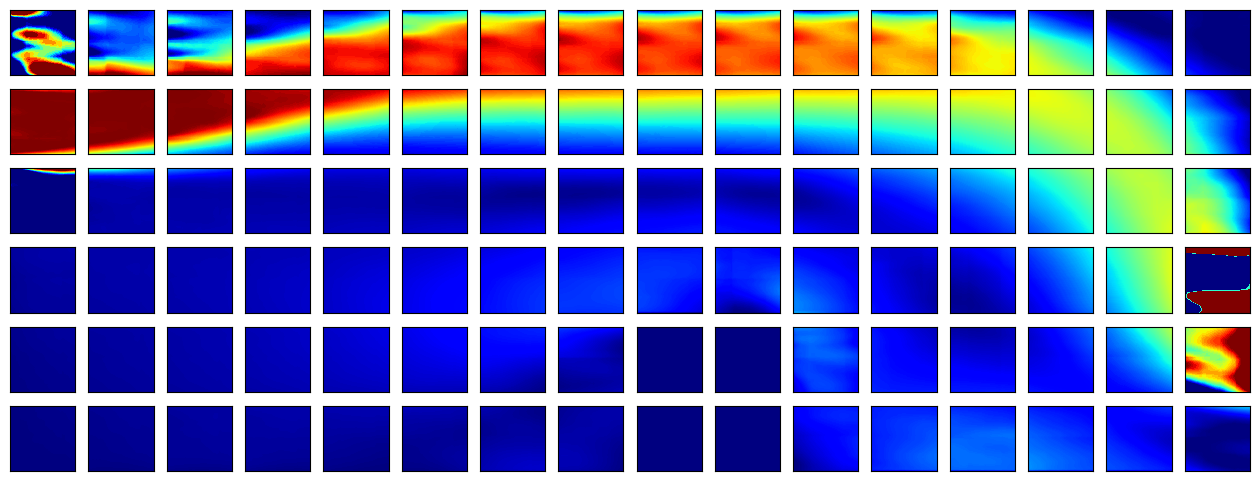

In [35]:
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate.cpu().detach().numpy()[:,0].reshape(51,51), coordinate.cpu().detach().numpy()[:,1].reshape(51,51), v_pred[i+j*6,:,:], 100, cmap='jet',vmin=0,vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])
plt.show()

Locator attempting to generate 9745 ticks ([-22.764, ..., 35.7]), which exceeds Locator.MAXTICKS (1000).


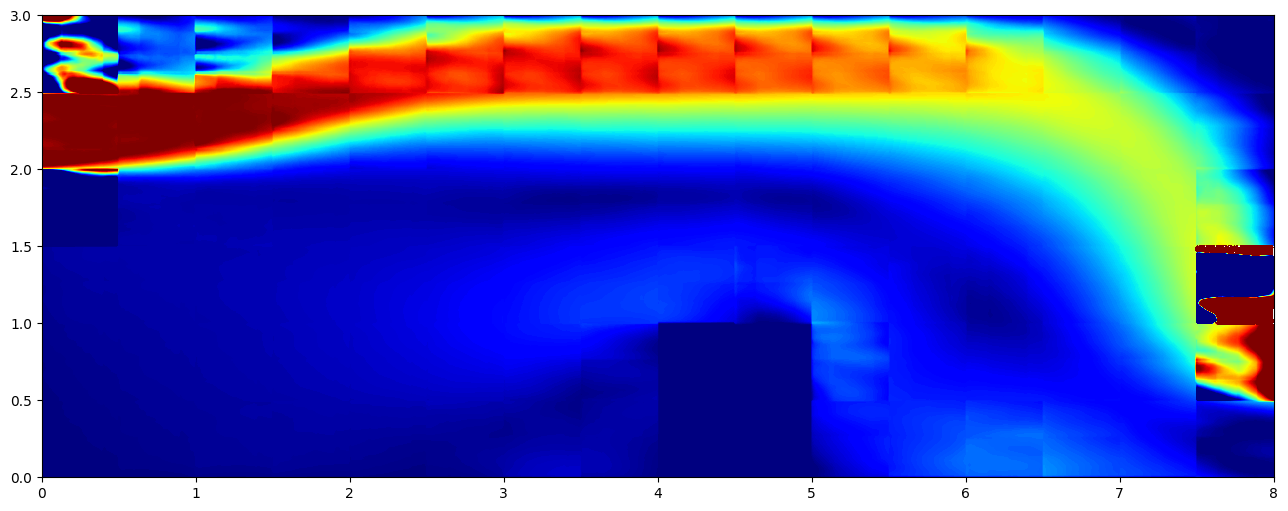

In [36]:
all_zone = np.zeros((300,800))
for i in range(6):
	for j in range(16):
		if i == 5 and j != 15:
			all_zone[-51:,j*50:(j+1)*50+1] = v_pred[i+j*6,:,:]
		elif i != 5 and j == 15:
			all_zone[i*50:(i+1)*50+1,-51:] = v_pred[i+j*6,:,:]
		elif i == 5 and j == 15:
			all_zone[-51:,-51:] = v_pred[i+j*6,:,:]
		else:
			all_zone[i*50:(i+1)*50+1,j*50:(j+1)*50+1] = v_pred[i+j*6,:,:]

fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,10000,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

In [28]:
train_data = np.load(r'train_data/train_data_velocity.npy')
print(train_data.shape)

(96, 51, 51, 1)


In [19]:
train_data = inverse_normalize(train_data,train_mean,train_std)

In [120]:
print(train_data.shape)
train_data = train_data.reshape(96,51,51,1)
print(train_data.shape)

torch.Size([96, 2601])
torch.Size([96, 51, 51, 1])


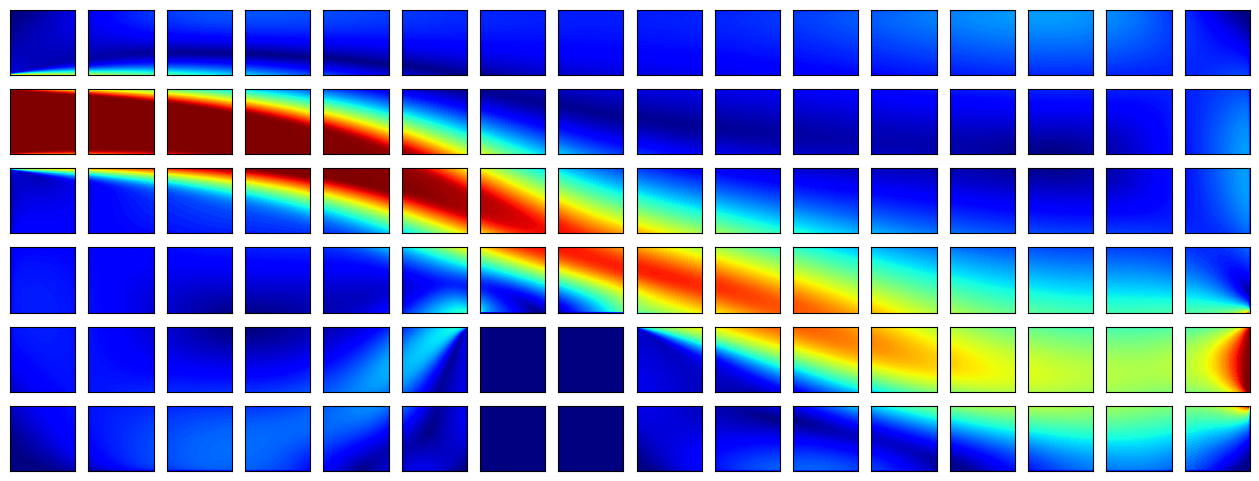

In [121]:
coordinate = np.meshgrid(np.linspace(0,0.5,51), np.linspace(0,0.5,51))
coordinate = np.stack((coordinate[0],coordinate[1]), axis=-1).reshape(-1,2)
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[:,0].reshape(51,51), coordinate[:,1].reshape(51,51), train_data[i+j*6,:,:,0], 100, cmap='jet',vmin=0,vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])
plt.show()

In [ ]:
a = all_zone
fig,axs = plt.subplots(1,figsize=(16,6))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),a,10000,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')